# igv variant classifier

In [5]:
from fastai.vision import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

image sizez: 500x425, should be square shape, just noticed that you can use rectangular images as well

some updates/improvement on this:

* during my first shot trial, I simply generated the igv screen shots as training images. There are quite a few shortcomings/ caveats in the image. For example,
      1) the top pane of the igv has the coordinates and a chromosome cytoband model. This should not have any useful information in determining if a variant is real or not.
      2) the left pane of the igv shows the bam file name, this should not have any useful graphic information in dtermining if a variant is real or not either.
      3) currently, images are 500x425 pixels. the resolution seems way too high. therotically for each base, we only need one pixel value. we take a screenshot for 300 base pairs. so set the width to be close to 300 and make the read width to be roughly one pixel. this will save lots of computations.
So I decided to crop out those part of the image.
* I turned off all the image transformations. It does not make sense to random rotate the image, cropping, zooming, warping, vertically flipping. I would like to keep the variant position in the centre of the image. horizontally flipping makes sense since the image should still support the same variants.
* there are some issues with the negative training images. previously, I just random pick some of the positions in the genome, which does not have a variant reported by GIAB project. But some of positions may have insufficient coverage or there is variant right next to the position in question. Also these negative samples are mostly too easy. I should come up with ways to include more challenging negative training set.
* it looks like fastai data block api can actually take rectangular images. will experiment if it works since this is especially relevant to igv screen shots. 


# this is the transformation i need

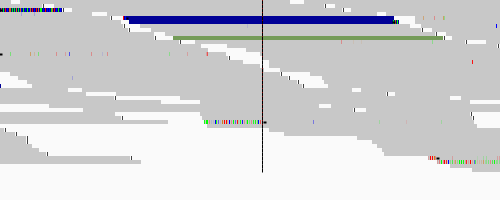

In [209]:
# crop from top with random centre
tfm = [crop(size=(200, 500), row_pct=0., col_pct=np.random.rand())]
get_ex(f).apply_tfms(tfm)

In [14]:
tfms = get_transforms(max_rotate=0)
len(tfms) # transformation for train and for validation. we dont want transform validation image except resizing.
tfms[1]

2

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

torch.Size([3, 500, 548])

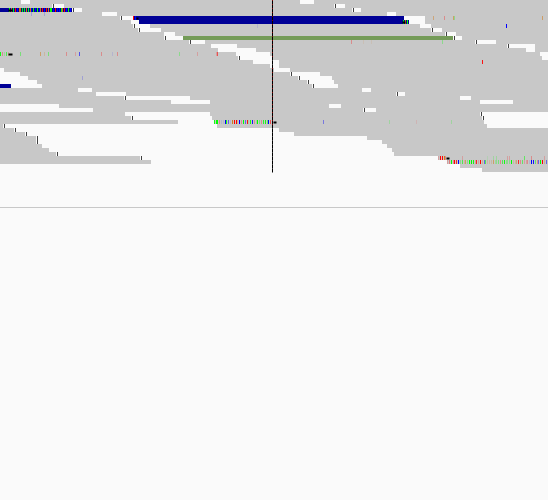

In [10]:
f = '/projects/da_workspace/szspace/data/giab/images/train/ps/chr10_101,123,131_101,123,431.png'
img = open_image(f)
img.shape
img

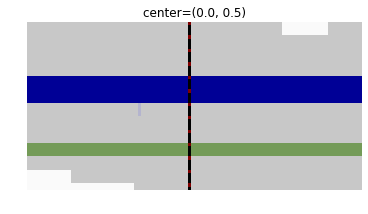

In [407]:
# it looks like this is the way to go: give a rectangular size and let the crop from top centre position (0., 0.5)
f, ax = plt.subplots()
centre = [0., 0.]
crop(img, (50, 100), *center).show(ax=ax, title=f'center=({center[0]}, {center[1]})')

In [7]:
# f = 'cat_example.jpg'
f = '/projects/da_workspace/szspace/data/giab/images/train/ps/chr10_101,123,131_101,123,431.png'
def get_ex(f): return open_image(f) # need to reopen the image every time you do a transformation


In [8]:
def plots_f(f, rows, cols, width, height, **kwargs):
    [get_ex(f).apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

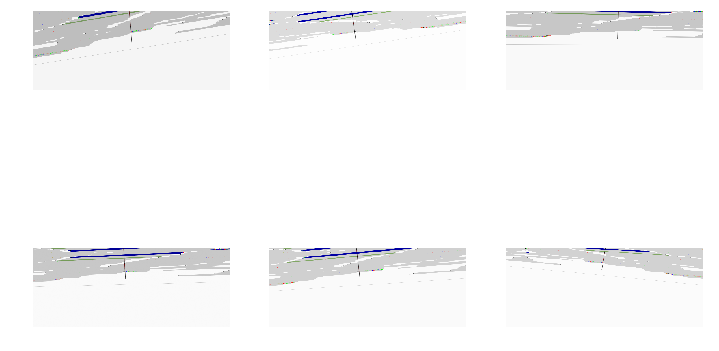

In [108]:

plots_f(f, 2, 3, 12, 8, size=(200, 500), padding_mode='reflection')

In [65]:
RandTransform??

In [183]:
np.random.rand()

0.5553320592202358

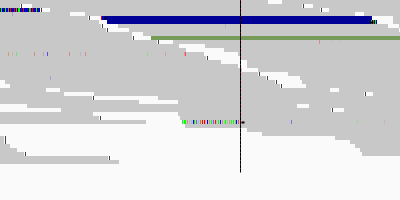

In [190]:
tfm = [crop(size=(200, 400), row_pct=0., col_pct=np.random.rand())]
get_ex(f).apply_tfms(tfm)

In [16]:
crop(get_ex(f), (200, 500), row)

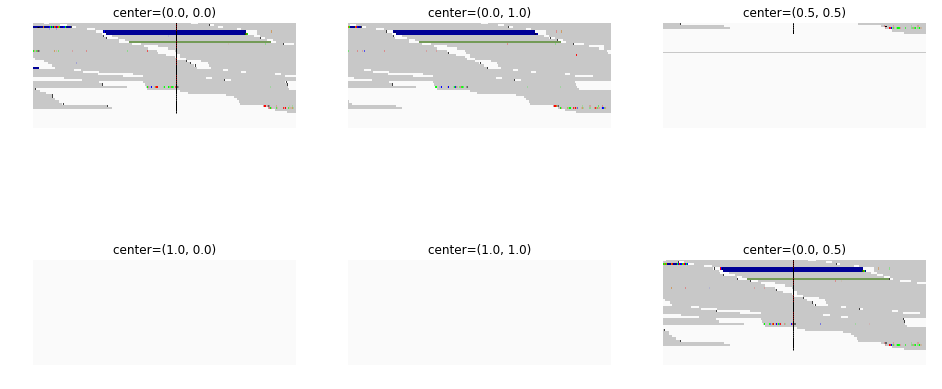

In [252]:
fig, axs = plt.subplots(2,3,figsize=(16,8))
for center, ax in zip([[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.], [0., 0.5]], axs.flatten()):
    crop(get_ex(f), (200, 500), *center).show(ax=ax, title=f'center=({center[0]}, {center[1]})')

In [111]:
# verify_images??
# get_image_files??

In [11]:
# for c in classes:
#     print(c)
#     verify_images(path/c, delete=True, max_size=500)

## View data

In [129]:
doc(get_transforms)

In [225]:
tfms = [crop(size=(200, 400), row_pct=0., col_pct=np.random.rand()), 
       crop(size=(200, 400), row_pct=0., col_pct=.5)]

In [221]:
path = Path('/projects/da_workspace/szspace/data/giab/images/train')
test_path = Path('/projects/da_workspace/szspace/data/giab/images/test')
classes = ['ps', 'ns']
bs = 64
img_sz = (200, 500)

tfms = get_transforms(
                        do_flip=True, 
                        flip_vert=False,                       
                        max_rotate=None, 
                        max_zoom=1., 
                        max_warp=None, 
                        max_lighting=None,
                        p_affine=0,
                        p_lighting=0 )

In [226]:
tfms

[RandTransform(tfm=TfmPixel (crop), kwargs={'size': (200, 400), 'row_pct': 0.0, 'col_pct': 0.30554301563237174}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
 RandTransform(tfm=TfmPixel (crop), kwargs={'size': (200, 400), 'row_pct': 0.0, 'col_pct': 0.5}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [414]:
# i want a transformation that always random crop from the top

In [344]:
ImageDataBunch.from_folder??

In [227]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, 
                                  train=".",
                                  test=test_path,
                                  valid_pct=0.2, 
                                  classes=classes,
                                  ds_tfms=tfms, 
                                  size=img_sz, bs=bs, 
                                  num_workers=4).normalize(imagenet_stats)

In [230]:
data

ImageDataBunch;

Train: LabelList (4475 items)
x: ImageList
Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400)
y: CategoryList
ps,ps,ps,ps,ps
Path: /projects/da_workspace/szspace/data/giab/images/train;

Valid: LabelList (1118 items)
x: ImageList
Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400)
y: CategoryList
ps,ps,ns,ps,ps
Path: /projects/da_workspace/szspace/data/giab/images/train;

Test: LabelList (2400 items)
x: ImageList
Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400),Image (3, 200, 400)
y: EmptyLabelList
,,,,
Path: /projects/da_workspace/szspace/data/giab/images/train

Good! Let's take a look at some of our pictures then.

In [365]:
path

PosixPath('/projects/da_workspace/szspace/data/giab/images/train')

In [231]:
data.classes

['ps', 'ns']

# why some centre line disappears
it seems centre lines are actually present in all preprocessed images. not sure why it disappears here. maybe the show batch function problem?

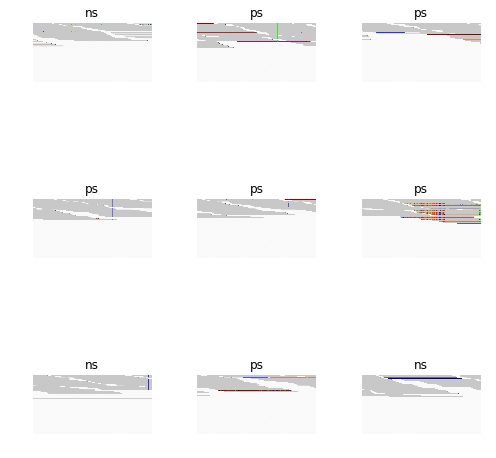

In [232]:
data.show_batch(rows=3, figsize=(7,8))

In [372]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['ps', 'ns'], 2, 4475, 1118, 2400)

In [256]:
data.train_ds

LabelList (4475 items)
x: ImageList
Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500)
y: CategoryList
ps,ps,ps,ps,ps
Path: /projects/da_workspace/szspace/data/giab/images/train

In [166]:
data.valid_ds

LabelList (1118 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
ps,ps,ns,ps,ps
Path: /projects/da_workspace/szspace/data/giab/images/train

In [167]:
data.test_ds

LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /projects/da_workspace/szspace/data/giab/images/train

## Train model

In [233]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [234]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


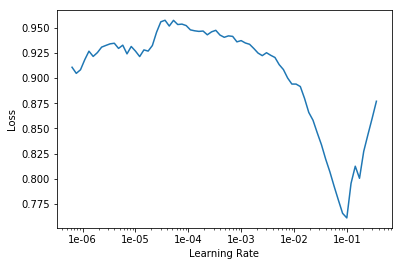

In [235]:
learn.recorder.plot()

In [236]:
learn.fit_one_cycle(4, max_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.362848,0.854887,0.692308,00:29
1,0.215090,0.680156,0.582290,00:28
2,0.108993,0.958747,0.592129,00:28
3,0.064474,0.742468,0.614490,00:29


In [377]:
learn.save('stage-1')

In [378]:
learn.unfreeze()

lr_find fail to run periodically, is this due to memery issue? no. it stops because the loss get much worse.

In [379]:
learn.lr_find(start_lr=1e-8, end_lr=1e-3, stop_div=False) # if stop_div=True it will stop when the loss get much worse

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [264]:
# learn.lr_find()

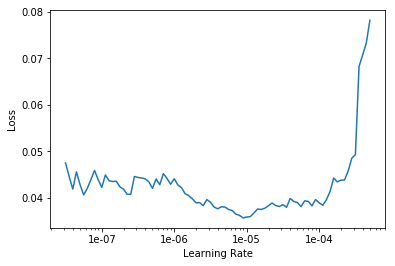

In [380]:
learn.recorder.plot()

In [266]:
# If the plot is not showing try to give a start and end learning rate# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [381]:
learn.fit_one_cycle(2, max_lr=5e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.036564,0.054977,0.981216,00:44
1,0.037815,0.057117,0.979428,00:43


In [382]:
learn.save('stage-2')

## Interpretation

In [383]:
learn.load('stage-2');

In [384]:
interp = ClassificationInterpretation.from_learner(learn)

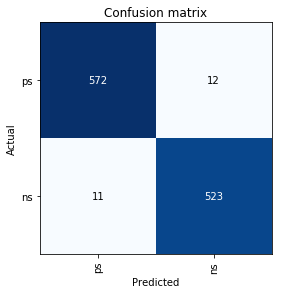

In [385]:
interp.plot_confusion_matrix()

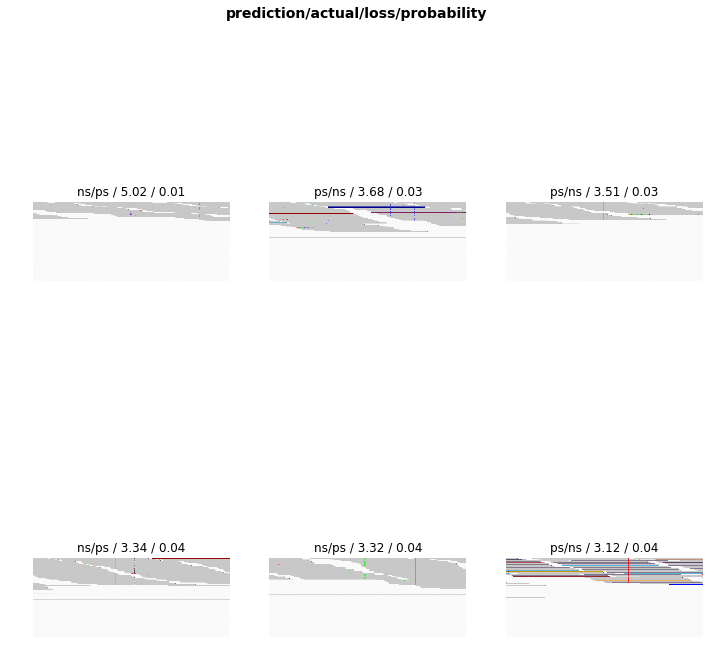

In [386]:
interp.plot_top_losses(6, heatmap=False)
# "Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class."

In [387]:
interp.ds

LabelList (1118 items)
x: ImageList
Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500)
y: CategoryList
ps,ps,ns,ps,ps
Path: /projects/da_workspace/szspace/data/giab/images/train

# heatmap

Category ps

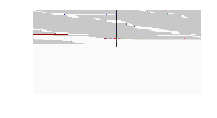

In [290]:
idx=935
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [291]:
m = learn.model.eval();

In [292]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

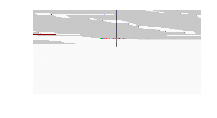

In [293]:
show_image(data.denorm(xb)[0])
# show_image(xb[0]) # normalized 

In [294]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

torch.Size([512, 7, 13])

torch.Size([7, 13])

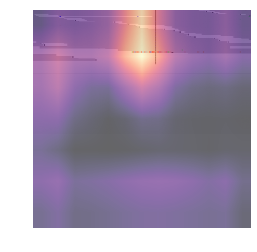

In [295]:
hook_a,hook_g = hooked_backward()
acts  = hook_a.stored[0].cpu()
acts.shape
avg_acts = acts.mean(0)
avg_acts.shape
show_heatmap(avg_acts)

# predict test set

by definition, test data set does not have labels, can I load the model and pretend the test set is validation set and get the test accuracy?

In [392]:
ImageDataBunch.from_folder??

In [400]:
path = '/projects/da_workspace/szspace/data/giab/images'
# there should not have other image folders in path
test_path


PosixPath('/projects/da_workspace/szspace/data/giab/images/test')

In [399]:
np.random.seed(42)
data_test = ImageDataBunch.from_folder(path, 
                                  train="train",
                                  valid='test',
#                                   valid_pct=0.2, 
                                  classes=classes,
                                  ds_tfms=tfms, 
                                  size=img_sz, bs=bs, 
                                  num_workers=4).normalize(imagenet_stats)

In [401]:
data_test

ImageDataBunch;

Train: LabelList (5593 items)
x: ImageList
Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500)
y: CategoryList
ps,ps,ps,ps,ps
Path: /projects/da_workspace/szspace/data/giab/images;

Valid: LabelList (2400 items)
x: ImageList
Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500)
y: CategoryList
ns,ns,ns,ns,ns
Path: /projects/da_workspace/szspace/data/giab/images;

Test: None

In [402]:
# set the model data attribute
learn.data = data_test
learn

Learner(data=ImageDataBunch;

Train: LabelList (5593 items)
x: ImageList
Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500)
y: CategoryList
ps,ps,ps,ps,ps
Path: /projects/da_workspace/szspace/data/giab/images;

Valid: LabelList (2400 items)
x: ImageList
Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500),Image (3, 200, 500)
y: CategoryList
ns,ns,ns,ns,ns
Path: /projects/da_workspace/szspace/data/giab/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05

accuracy is 0.9829166531562805


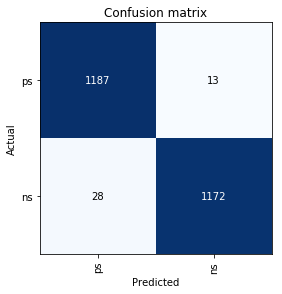

In [403]:
interp = ClassificationInterpretation.from_learner(learn)
acc = (interp.pred_class == interp.y_true).float().mean()
print(f'accuracy is {acc}')
interp.plot_confusion_matrix()

# need to read in test set labels

# train with 256x256 size image

In [52]:
learn.data

ImageDataBunch;

Train: LabelList (3203 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negatives,negatives,negatives,negatives,negatives
Path: /projects/da_workspace/szspace/data/giab/images;

Valid: LabelList (800 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negatives,positives,positives,negatives,positives
Path: /projects/da_workspace/szspace/data/giab/images;

Test: None

In [53]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.026151,0.073532,0.017500,00:16
1,0.019644,0.065938,0.013750,00:16


## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [12]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [13]:
defaults.device = torch.device('cpu')

In [1]:
img = open_image(path/'black'/'00000021.jpg')


NameError: name 'open_image' is not defined

In [15]:
learn = load_learner(path)

pred_class,pred_idx,outputs = learn.predict(img)
pred_class

(500, 425)

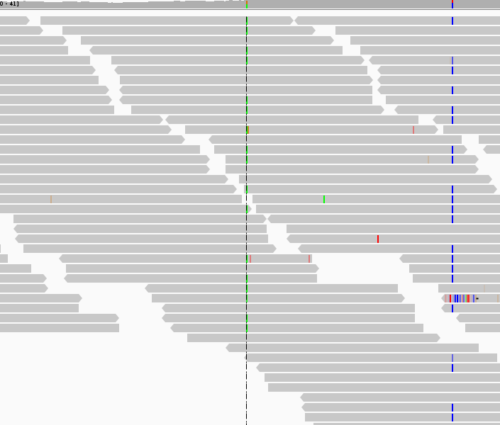

(425, 500, 3)

In [124]:
from PIL import Image
imf = '/projects/da_workspace/szspace/data/giab/images/positives/chr1_216,003,182_216,003,482.png'
im = Image.open(imf)
im.rotate(45).show()# use pillow
im.size # width, height
im
arr = np.array(im)
arr.shape

In [125]:
arr

array([[[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [175, 175, 175],
        [175, 175, 175],
        [175, 175, 175],
        [175, 175, 175]],

       [[160, 160, 160],
        [120, 120, 120],
        [176, 176, 176],
        [207, 207, 207],
        ...,
        [175, 175, 175],
        [175, 175, 175],
        [175, 175, 175],
        [175, 175, 175]],

       [[ 70,  70,  70],
        [116, 116, 116],
        [ 85,  85,  85],
        [175, 175, 175],
        ...,
        [175, 175, 175],
        [175, 175, 175],
        [175, 175, 175],
        [175, 175, 175]],

       [[ 61,  61,  61],
        [172, 172, 172],
        [ 67,  67,  67],
        [175, 175, 175],
        ...,
        [175, 175, 175],
        [175, 175, 175],
        [175, 175, 175],
        [175, 175, 175]],

       ...,

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [227, 